In [1]:
#Libraries
from collections import Counter
from dotenv import load_dotenv
# from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd
import geopy.distance
import json
import os
import pandas as pd
from pymongo import MongoClient, GEOSPHERE
import requests

In [2]:
#Functions from .py
from src.clean import foursquare, walking, mapping

In [3]:
client = MongoClient("localhost:27017")

In [4]:
db = client["Ironhack"]

In [5]:
# Retrieving the dataset
c=db.get_collection("companies")

In [6]:
# Filter for Design companies --> Only found 4
filter_design = {"category_code":"design"}
projection_design = {"_id":0, "name":1, "offices.city":1}
list(c.find(filter_design, projection_design))

[{'name': '99designs',
  'offices': [{'city': 'San Francisco'},
   {'city': 'Collingwood'},
   {'city': 'Berlin'}]},
 {'name': 'Graticle', 'offices': [{'city': 'Ellensburg'}]},
 {'name': 'Kickstarter', 'offices': [{'city': 'Brooklyn'}]},
 {'name': 'Moonfruit', 'offices': [{'city': 'London'}]}]

In [7]:
# Check distinct values for industry to define tech industry
list(c.distinct("category_code"))[:5]

[None, 'advertising', 'analytics', 'automotive', 'biotech']

In [8]:
# Creating a tech list with tech industries
tech = ['biotech','cleantech','ecommerce','games_video','nanotech','software','web']

In [9]:
# Check list of latest founded years.
list(c.distinct("founded_year"))[-4:]

[2010, 2011, 2012, 2013]

In [10]:
c.find_one()["funding_rounds"][0]['raised_amount']

5250000

In [11]:
# Filter tech companies for startup criteria
filter_tech = {"category_code":{"$in":tech}}
filter_year = {"founded_year":{"$gte":2000}}
filter_funding = {"funding_rounds.raised_amount":{"$gte":1000000}}
filter_employees={"number_of_employees":{"$lte":100}}

In [12]:
# List of filters with all filters
all_filters=[ filter_tech, filter_year, filter_funding, filter_employees ]

In [13]:
# Apply all filters applied to 'c'
projection_3 = {"_id":0,"offices":1}
x=list(c.find({"$and": all_filters}, projection_3))
x[0]

{'offices': [{'description': '',
   'address1': '710 - 2nd Avenue',
   'address2': 'Suite 1100',
   'zip_code': '98104',
   'city': 'Seattle',
   'state_code': 'WA',
   'country_code': 'USA',
   'latitude': 47.603122,
   'longitude': -122.333253},
  {'description': '',
   'address1': '270 Lafayette Street',
   'address2': 'Suite 505',
   'zip_code': '10012',
   'city': 'New York',
   'state_code': 'NY',
   'country_code': 'USA',
   'latitude': 40.7237306,
   'longitude': -73.9964312}]}

In [14]:
# Check an individual element to design the 'for' loop
x[0]['offices'][0]['city']

'Seattle'

In [15]:
# List of cities from offices from companies
cities=[j['city'] for i in x for j in i['offices'] ]
cities[:10]

['Seattle',
 'New York',
 'West Hollywood',
 'New York',
 'Sunnyvale',
 'Culver City',
 'San Francisco',
 'New York',
 'Pleasanton',
 'Luxembourg City']

In [16]:
#Top 10 count of city mentions.
counts = pd.Series(cities).value_counts()
print(counts[:10])

San Francisco    61
New York         57
London           31
Seattle          23
San Mateo        20
Palo Alto        16
Paris            15
Los Angeles      12
Cambridge        12
Sunnyvale        10
dtype: int64


In [17]:
# Best cities to work as a Designer
# https://www.designrush.com/agency/graphic-design/trends/top-countries-and-cities-for-design-jobs#:~:text=New%20York%20City%20is%20an,of%20the%20best%20design%20talent
print('Best cities to work as a Designer:')
print('    - San Francisco\n    - New York\n    - London\n\nBerlin\nToronto\nMontreal\nBoston')

Best cities to work as a Designer:
    - San Francisco
    - New York
    - London

Berlin
Toronto
Montreal
Boston


In [18]:
# Cross reference both and we got our 3 cities: San Francisco, New York & London.

In [19]:
# Our online research shows the best quality of life is in San Francisco, therefore we will pick a centered location

In [20]:
# Creating a DF with the Startups we found on the companies db.
new_list = [{"name" : 'Startup (before 2013)',
             "lat"  : j["latitude"],
             "long" : j["longitude"], 
             "type" : {"typepoint": {"type": "Point"}}} for i in x for j in i['offices'] if j['city']=='San Francisco']
#Drop empty and incorrect values
df_startup = pd.DataFrame(new_list).dropna().reset_index(drop=True)
for index, row in df_startup.iterrows():
    if (int(row['lat']) != 37) | (int(row['long'])!=-122) | index==15 :
        df_startup = df_startup.drop(index)
df_startup = df_startup.reset_index(drop=True)
df_startup.sample()

,name,lat,long,type
5,Startup (before 2013),37.782263,-122.392142,{'typepoint': {'type': 'Point'}}


In [21]:
#Credentials
load_dotenv()
key = os.getenv("key")

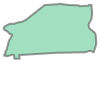

In [22]:
# Location on the Mission disctrict based on recent Tech Startup cluster
location = [37.7615584,-122.4155738]
radius=10000
limit=10
data = gpd.read_file("/Users/nicostan/Downloads/Ironhack/labs/Project-III/jsons-input/san-francisco.geojson")
data['geometry'][3]

In [23]:
# Creating Dataframes from Foursquare queries
df1 = foursquare (key,"Design Studio", location, radius, 15)
df2 = foursquare (key,"Children School", location, radius, 5)
df3 = foursquare (key,"Startup", location, radius, 15) #Get more updated results for Startups.
df4 = foursquare (key,"Starbucks", location, radius, 10)
df5 = foursquare (key,"San Francisco International Airport", location, 30000, 1)
df6 = foursquare (key,"Bar", location, radius, 10)
df7 = foursquare (key,"Vegan Restaurant", location, radius, 5)
df8 = foursquare (key,"Basketball Stadium", location, 5000, 1)
df9 = foursquare (key,"Pet Grooming", location, radius, 5)
df= pd.concat([df_startup, df1, df2, df3, df4, df5, df6, df7, df8, df9], ignore_index=True)

In [33]:
# Showing San Francisco Districts and Company through Cartoframes.
from cartoframes.viz import Map, Layer, popup_element, color_category_style
temp_list = [ {"name" : "Hourglass Games",
              "lat"  : location[0],
              "long" : location[1],
              "type" : {"typepoint":
                          {"type": "Point",
                           "coordinates": [location[0], location[1]]}}} ]
df_temp = pd.DataFrame(temp_list)
df_geo = gpd.GeoDataFrame(df_temp, geometry=gpd.points_from_xy(df_temp["long"], df_temp["lat"]))
Map([Layer(data, color_category_style('DISTRICT'), popup_hover=[popup_element("DISTRICT")]), Layer(df_geo, 'color:red',popup_hover=[popup_element("name")])])

In [25]:
from folium import Choropleth, Circle, FeatureGroup, GeoJson, Icon, LayerControl, Map, Marker, Popup

In [30]:
sf_map = Map(location, zoom_start = 12)

In [27]:
company = Marker(location, tooltip="Hourglass Games", icon=Icon(color="black",
           opacity=0.1,
           prefix="fa", #It comes from Font Awesome
           icon="database",
           icon_color="green"))
company.add_to(sf_map)

In [118]:
#This would be useful were we to consider neighborhoods at a later stage.
import random as rd
list_of_colors=['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray ']
sample=rd.sample(list_of_colors, data.shape[0])
sf_map_temp=sf_map

for i, r in data.iterrows():
    # Without simplifying the representation of each borough, the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = GeoJson(data=geo_j, name= r['DISTRICT'],
                           style_function=lambda x: {'fillColor': sample[i]}, tooltip=r['DISTRICT'])
    geo_j.add_to(sf_map_temp)
LayerControl(collapsed=False).add_to(sf_map_temp)
sf_map_temp

In [31]:
walking(sf_map, location)

In [32]:
# Add foursquare queried locations to the map
sf_map=mapping(sf_map, df, location)
LayerControl(collapsed=False).add_to(sf_map)
sf_map